In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = "eval_results/atlanta"
temperature_humidity = "73_83"

In [3]:

idm_data_0 = pd.read_csv(data_path + "/IDM/stats.csv")
ddpg_data_33 = pd.read_csv(data_path + "/DDPG/stats.csv")
ppo_data_33 = pd.read_csv(data_path + "/PPO/stats.csv")

In [4]:
approach_emission_column_name = "evaluation_sampler_results_custom_metrics_regular_approach_vehicle_emission_" + temperature_humidity + "_mean"
num_vehicles_column_name = "evaluation_sampler_results_custom_metrics_num_vehicle_mean"
speed_column_name = "evaluation_sampler_results_custom_metrics_approach_vehicle_speed_mean"

approach_name_column_name = "evaluation_sampler_results_custom_metrics_single_approach_mean"
intersection_id_column_name = "evaluation_sampler_results_custom_metrics_intersection_id_mean"

In [5]:
idm_data_0 = idm_data_0[[approach_emission_column_name, num_vehicles_column_name, \
    speed_column_name, approach_name_column_name, intersection_id_column_name]]
ddpg_data_33 = ddpg_data_33[[approach_emission_column_name, num_vehicles_column_name, \
    speed_column_name, approach_name_column_name, intersection_id_column_name]]
ppo_data_33 = ppo_data_33[[approach_emission_column_name, num_vehicles_column_name, \
    speed_column_name, approach_name_column_name, intersection_id_column_name]]

In [6]:
new_approach_emission_column_name = "emission"
new_num_vehicles_column_name = "num_vehicle"
new_speed_column_name = "speed"

idm_data_0 = idm_data_0.rename(columns={approach_emission_column_name: new_approach_emission_column_name, \
    num_vehicles_column_name: new_num_vehicles_column_name, speed_column_name: new_speed_column_name})
ddpg_data_33 = ddpg_data_33.rename(columns={approach_emission_column_name: new_approach_emission_column_name, \
     num_vehicles_column_name: new_num_vehicles_column_name, speed_column_name: new_speed_column_name})
ppo_data_33 = ppo_data_33.rename(columns={approach_emission_column_name: new_approach_emission_column_name, \
    num_vehicles_column_name: new_num_vehicles_column_name, speed_column_name: new_speed_column_name})

idm_data_0['approach_intersection'] = idm_data_0[intersection_id_column_name].astype(str) \
            + "_" + idm_data_0[approach_name_column_name].astype(str)
ddpg_data_33['approach_intersection'] = ddpg_data_33[intersection_id_column_name].astype(str) \
            + "_" + ddpg_data_33[approach_name_column_name].astype(str)
ppo_data_33['approach_intersection'] = ppo_data_33[intersection_id_column_name].astype(str) \
            + "_" + ppo_data_33[approach_name_column_name].astype(str)

idm_data_0 = idm_data_0.drop(columns=[approach_name_column_name, intersection_id_column_name])
ddpg_data_33 = ddpg_data_33.drop(columns=[approach_name_column_name, intersection_id_column_name])
ppo_data_33 = ppo_data_33.drop(columns=[approach_name_column_name, intersection_id_column_name])

idm_data_0 = idm_data_0.sort_values(by=['approach_intersection'])
ddpg_data_33 = ddpg_data_33.sort_values(by=['approach_intersection'])
ppo_data_33 = ppo_data_33.sort_values(by=['approach_intersection'])

print(idm_data_0.head(10))

        emission  num_vehicle      speed approach_intersection
3459   21.827469        112.0   7.071159               0.0_0.0
3460  104.673843         70.0  11.526550               0.0_0.0
3461  104.126974         71.0   9.913401               0.0_0.0
3462  101.539884         73.0  11.158842               0.0_1.0
3463   70.842359         77.0   7.119032               0.0_1.0
3464   63.198014         69.0   7.871668               0.0_1.0
3465   65.872295         66.0   7.989211               0.0_2.0
3466   71.220147        165.0   9.353382               0.0_2.0
3467   68.302131        164.0   9.607198               0.0_2.0
1482   66.539500        135.0   1.064283               1.0_0.0


In [7]:
# average the rows with the same approach_intersection value
idm_data_0 = idm_data_0.groupby(['approach_intersection']).mean().reset_index()
ddpg_data_33 = ddpg_data_33.groupby(['approach_intersection']).mean().reset_index()
ppo_data_33 = ppo_data_33.groupby(['approach_intersection']).mean().reset_index()

print(idm_data_0.head(10))

  approach_intersection    emission  num_vehicle         speed
0               0.0_0.0   76.876095    84.333333  9.503703e+00
1               0.0_1.0   78.526752    73.000000  8.716514e+00
2               0.0_2.0   68.464858   131.666667  8.983264e+00
3               1.0_0.0   28.738249    45.666667  3.602200e+00
4               1.0_1.0   22.061687    21.333333  2.149166e+00
5               1.0_2.0   93.318278    33.000000  6.950999e-01
6               1.0_3.0  152.905287    79.333333  2.693162e+00
7               1.0_4.0  167.468852    99.666667  3.841341e+00
8               1.0_5.0  144.004912    51.333333  2.049349e+00
9               1.0_6.0   65.720140    85.000000  6.666667e+06


In [8]:
idm_data_0['ddpg_emission'] = 0.0
idm_data_0['ppo_emission'] = 0.0

ddpg_success = 0
ppo_success = 0

for index, row in idm_data_0.iterrows():
    ddpg_row = ddpg_data_33.loc[ddpg_data_33['approach_intersection'] == row['approach_intersection']]
    ppo_row = ppo_data_33.loc[ppo_data_33['approach_intersection'] == row['approach_intersection']]
    if row['num_vehicle'] <= ddpg_row['num_vehicle'].values[0]:
        idm_data_0.at[index, 'ddpg_emission'] = ddpg_row['emission'].values[0]
        idm_data_0.at[index, 'ddpg_num_vehicle'] = ddpg_row['num_vehicle'].values[0]
        ddpg_success += 1
    else:
        idm_data_0.at[index, 'ddpg_emission'] = row['emission']
        idm_data_0.at[index, 'ddpg_num_vehicle'] = row['num_vehicle']

    if row['num_vehicle'] <= ppo_row['num_vehicle'].values[0]:
        idm_data_0.at[index, 'ppo_emission'] = ppo_row['emission'].values[0]
        idm_data_0.at[index, 'ppo_num_vehicle'] = ppo_row['num_vehicle'].values[0]
        ppo_success += 1
    else:
        idm_data_0.at[index, 'ppo_emission'] = row['emission']
        idm_data_0.at[index, 'ppo_num_vehicle'] = row['num_vehicle']

print(idm_data_0.head(10))

  approach_intersection    emission  num_vehicle         speed  ddpg_emission  \
0               0.0_0.0   76.876095    84.333333  9.503703e+00      76.876095   
1               0.0_1.0   78.526752    73.000000  8.716514e+00      76.868922   
2               0.0_2.0   68.464858   131.666667  8.983264e+00      71.807936   
3               1.0_0.0   28.738249    45.666667  3.602200e+00      25.969739   
4               1.0_1.0   22.061687    21.333333  2.149166e+00      21.057770   
5               1.0_2.0   93.318278    33.000000  6.950999e-01      95.261357   
6               1.0_3.0  152.905287    79.333333  2.693162e+00     147.676875   
7               1.0_4.0  167.468852    99.666667  3.841341e+00     167.468852   
8               1.0_5.0  144.004912    51.333333  2.049349e+00     165.262280   
9               1.0_6.0   65.720140    85.000000  6.666667e+06      65.720140   

   ppo_emission  ddpg_num_vehicle  ppo_num_vehicle  
0     76.876095         84.333333        84.333333  
1 

In [9]:
idm_data_0['ddpg_emission_diff'] = idm_data_0['emission'] - idm_data_0['ddpg_emission']
idm_data_0['ppo_emission_diff'] = idm_data_0['emission'] - idm_data_0['ppo_emission']

idm_data_0['ddpg_emission_diff_percentage'] = idm_data_0['ddpg_emission_diff'] / idm_data_0['emission']
idm_data_0['ppo_emission_diff_percentage'] = idm_data_0['ppo_emission_diff'] / idm_data_0['emission']

print("ddpg throughput success percentage: ", ddpg_success / len(idm_data_0) * 100, "%")
print("ppo throughput success percentage: ", ppo_success / len(idm_data_0) * 100, "%")

ddpg throughput success percentage:  62.871747211895915 %
ppo throughput success percentage:  26.579925650557623 %


In [10]:
ddpg_better = idm_data_0[idm_data_0['ddpg_emission_diff_percentage'] < 0]
ppo_better = idm_data_0[idm_data_0['ppo_emission_diff_percentage'] < 0]

print("ddpg emission success percentage: ", len(ddpg_better)/len(idm_data_0) * 100, "%")
print("ppo emission success percentage: ", len(ppo_better)/len(idm_data_0) * 100, "%")

ddpg emission success percentage:  38.847583643122675 %
ppo emission success percentage:  24.302973977695167 %


In [11]:
idm_emission_sum = idm_data_0['emission'].sum()
idm_num_vehicle_sum = idm_data_0['num_vehicle'].sum()

ddpg_emission_sum = idm_data_0['ddpg_emission'].sum()
ddpg_num_vehicle_sum = idm_data_0['ddpg_num_vehicle'].sum()

ppo_emission_sum = idm_data_0['ppo_emission'].sum()
ppo_num_vehicle_sum = idm_data_0['ppo_num_vehicle'].sum()

print("ddpg emission average benefit percentage: ", (idm_emission_sum - ddpg_emission_sum)/idm_emission_sum * 100, "%")
print("ppo emission average benefit percentage: ", (idm_emission_sum - ppo_emission_sum)/idm_emission_sum * 100, "%")

print("ddpg num_vehicle average benefit percentage: ", (ddpg_num_vehicle_sum- idm_num_vehicle_sum)/idm_num_vehicle_sum * 100, "%")
print("ppo num_vehicle average benefit percentage: ", (ppo_num_vehicle_sum - idm_num_vehicle_sum)/idm_num_vehicle_sum * 100, "%")

ddpg emission average benefit percentage:  -1.2850594304293947 %
ppo emission average benefit percentage:  -14.858147438583517 %
ddpg num_vehicle average benefit percentage:  4.445033661967937 %
ppo num_vehicle average benefit percentage:  2.691349484602382 %


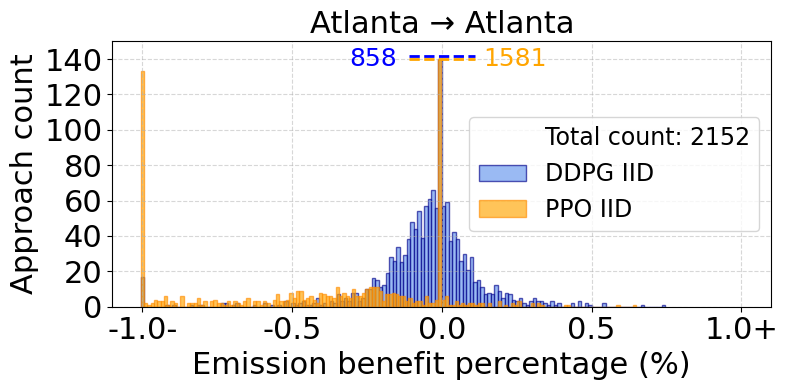

In [12]:
emission_benefit_cap = 1.0 # pecentage
frequency_cap = 140
bins = 150
font_size= 22

idm_data_0['ddpg_emission_diff_percentage'] = idm_data_0['ddpg_emission_diff_percentage'].clip(-1*emission_benefit_cap, emission_benefit_cap)
idm_data_0['ppo_emission_diff_percentage'] = idm_data_0['ppo_emission_diff_percentage'].clip(-1*emission_benefit_cap, emission_benefit_cap)

data_ddpg = idm_data_0['ddpg_emission_diff_percentage']
data_ppo = idm_data_0['ppo_emission_diff_percentage']

data_ddpg = data_ddpg.dropna()
data_ppo = data_ppo.dropna()

hist_ddpg, bins_ddpg = np.histogram(data_ddpg, bins=bins)
hist_ppo, bins_ppo = np.histogram(data_ppo, bins=bins)

hist_ddpg_clone = hist_ddpg.copy()
hist_ppo_clone = hist_ppo.copy()

hist_ddpg[hist_ddpg > frequency_cap] = frequency_cap
hist_ppo[hist_ppo > frequency_cap] = frequency_cap

plt.figure(figsize=(10, 6))  

plt.bar(bins_ddpg[:-1], hist_ddpg, width=(bins_ddpg[1]-bins_ddpg[0]), alpha=0.65, label='DDPG IID', color='cornflowerblue', edgecolor='darkblue')  
plt.bar(bins_ppo[:-1], hist_ppo, width=(bins_ppo[1]-bins_ppo[0]), alpha=0.65, label='PPO IID', color='orange', edgecolor='darkorange') 

plt.plot([], [], color='white', label='Total count: ' + str(len(idm_data_0)), linewidth=0)

plt.ylim(0, frequency_cap + 10)

plt.xlabel('Emission benefit percentage (%)', fontsize=font_size)   
plt.ylabel('Approach count', fontsize=font_size)  

plt.legend(loc='center right', fontsize=font_size-5)

plt.xlim(-1*emission_benefit_cap-0.1, emission_benefit_cap+0.1)
plt.xticks(ticks=[-1.0, -0.5, 0.0, 0.5, 1.0], labels=['-1.0-', '-0.5', '0.0', '0.5', '1.0+'])
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.gcf().set_size_inches(8, 4)

plt.axhline(y=141.7, xmin=0.45, xmax=0.55, color='blue', linestyle='--', linewidth=2) 
plt.axhline(y=140, xmin=0.45, xmax=0.55, color='orange', linestyle='--', linewidth=2) 

plt.text(-0.15, 140, str(max(hist_ddpg_clone)), color='blue', fontsize=font_size-4, ha='right', va='center') 
plt.text(0.35, 140, str(max(hist_ppo_clone)), color='orange', fontsize=font_size-4, ha='right', va='center')


plt.title('Atlanta \u2192 Atlanta', fontsize=font_size) 

plt.grid(True, linestyle='--', alpha=0.5) 
plt.tight_layout()  
plt.show()
